# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1uAUJGEUzfNj6OsWNAimnYCw7eKaHhMUfU1MTj9YwYw4/edit?usp=sharing), [grading rubric](https://docs.google.com/document/d/1hKuRWqFcIdhOkow3Nljcm7PXzIkoa9c_aHkMKZDxWa0/edit?usp=sharing)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an outline to help you with your own approach.**_

## Project Setup

In [16]:
# all import statements needed for the project, for example:

import math
import os
import re

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import geopandas as gpd
from keplergl import KeplerGl

In [17]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "data/taxi_zones"
TAXI_PARQUET_DIR = "data/taxi_parquet"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
UBER_CSV = "data/uber_rides_sample.csv"
WEATHER_CSV_DIR = "data/weather"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [18]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones

In [ ]:
def load_taxi_zones(shapefile):
    taxi_zones = gpd.read_file(filename=shapefile)
    taxi_zones = taxi_zones.to_crs(CRS)
    taxi_zones['longitude'] = taxi_zones.centroid.x
    taxi_zones['latitude'] = taxi_zones.centroid.y
    taxi_zones = taxi_zones[['longitude', 'latitude']]
    return taxi_zones

In [ ]:
def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
    return loaded_taxi_zones.loc[zone_loc_id, "latitude"], loaded_taxi_zones.loc[zone_loc_id, "longitude"]

### Calculate distance

In [ ]:
def calculate_distance_with_coords(from_coord, to_coord):
    pickup_lat, pickup_long = from_coord.iloc[:,0], from_coord.iloc[:,1]
    dropoff_lat, dropoff_long = to_coord.iloc[:,0], to_coord.iloc[:,1]    
    return 12742 * (((((dropoff_lat - pickup_lat)/2).map(math.sin))**2 + (pickup_lat.map(math.cos)) * (dropoff_lat.map(math.cos)) * (((dropoff_long - pickup_long)/2).map(math.sin))**2)**0.5).map(math.asin)

In [ ]:
def calculate_distance_with_zones(from_zone, to_zone):
    raise NotImplementedError()

In [ ]:
def add_distance_column(dataframe):
    dataframe['distance'] = calculate_distance_with_coords(dataframe[['pickup_latitude', 'pickup_longitude']], dataframe[['dropoff_latitude', 'dropoff_longitude']])
    return dataframe

### Process Taxi Data

In [ ]:
def get_all_urls_from_taxi_page(taxi_page):
    response = requests.get(TAXI_URL)
    soup = bs4.BeautifulSoup(response.text, "html.parser")
    urls = soup.select('a[title="Yellow Taxi Trip Records"]')
    return urls

In [ ]:
def filter_taxi_parquet_urls(all_urls):
    pattern = r"2009|201[0-4]|2015-0[1-6]"
    parquet_urls = []
    
    for url in all_urls:
        href = url["href"]
        if re.search(pattern, href):
            parquet_urls.append(href)
        
    return parquet_urls

In [ ]:
def get_and_clean_month(url, loaded_taxi_zones):
    fname = url[url.rfind("/")+1:]
    fpath = os.path.join(TAXI_PARQUET_DIR, fname)
    if os.path.exists(fpath):
        df=pd.read_parquet(fpath)
    else:
        df = pd.read_parquet(url)
    
    if 'DOLocationID' in df:
        df['pickup_latitude'], df['pickup_longitude'] = lookup_coords_for_taxi_zone_id(df['PULocationID'], loaded_taxi_zones)
        df['dropoff_latitude'], df['dropoff_longitude']= lookup_coords_for_taxi_zone_id(df['DOLocationID'], loaded_taxi_zones)
    
    df.rename(columns={'tpep_pickup_datetime':'pickup_datetime' ,'Start_Lon':'pickup_longitude', 'Start_Lat':'pickup_latitude', 'End_Lon':'dropoff_longitude', 'End_Lat':'dropoff_latitude','Tip_Amt':'tip_amount'}, inplace=True)
    df = df[['pickup_datetime', 'pickup_latitude','pickup_longitude', 'dropoff_latitude','dropoff_longitude', 'tip_amount']]
        
    lower_lat, lower_long = NEW_YORK_BOX_COORDS[0]
    upper_lat, upper_long = NEW_YORK_BOX_COORDS[1]
    
    df = df[(df['tip_amount'] >= 0)]
    
    df = df[(df['pickup_latitude'] >= lower_lat) & (df['pickup_latitude'] <= upper_lat)]
    df = df[(df['pickup_longitude'] >= lower_long) & (df['pickup_longitude'] <= upper_long)]
    df = df[(df['dropoff_latitude'] >= lower_lat) & (df['dropoff_latitude'] <= upper_lat)]
    df = df[(df['dropoff_longitude'] >= lower_long) & (df['dropoff_longitude'] <= upper_long)]

    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df["pickup_latitude"] = pd.to_numeric(df["pickup_latitude"], errors = "coerce")
    df["pickup_longitude"] = pd.to_numeric(df["pickup_longitude"], errors = "coerce")
    df["dropoff_latitude"] = pd.to_numeric(df["dropoff_latitude"], errors = "coerce")
    df["dropoff_longitude"] = pd.to_numeric(df["dropoff_longitude"], errors = "coerce")
    df["tip_amount"] = pd.to_numeric(df["tip_amount"], errors = "coerce")
    
    df = df.dropna().sort_values(by="pickup_datetime")
    df.index = range(df.shape[0])
    
    return df

In [ ]:
def get_and_clean_taxi_data(parquet_urls):
    all_taxi_dataframes = []
    loaded_taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
    
    for parquet_url in parquet_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month(parquet_url, loaded_taxi_zones)
        add_distance_column(dataframe)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.contact(all_taxi_dataframes)
    return taxi_data

In [ ]:
def get_taxi_data():
    all_urls = get_all_urls_from_taxi_page(TAXI_URL)
    all_parquet_urls = filter_taxi_parquet_urls(all_urls)
    taxi_data = get_and_clean_taxi_data(all_parquet_urls)
    return taxi_data

In [ ]:
taxi_data = get_taxi_data()

In [20]:
taxi_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,distance
Unnamed: 0,,,,,,,
11723032,2015-01-29 23:42:29,-73.977570,40.764420,-73.954740,40.765484,0.00,1.926106
11591956,2015-01-29 18:54:33,-73.985940,40.727620,-73.990456,40.740337,0.00,1.464508
9253077,2015-01-23 02:59:00,-74.008990,40.735035,-73.985940,40.727620,0.00,2.109891
3127418,2015-01-09 05:38:17,-73.989845,40.762253,-73.996920,40.720890,3.65,4.637764
6467808,2015-01-16 16:31:54,-73.989845,40.762253,-74.004010,40.753307,0.00,1.553517


### Processing Uber Data

In [21]:
def load_and_clean_uber_data(csv_file):
    df = pd.read_csv(UBER_CSV, index_col=[0])
    
    df = df[['pickup_datetime', 'pickup_latitude','pickup_longitude', 'dropoff_latitude','dropoff_longitude']]
        
    lower_lat, lower_long = NEW_YORK_BOX_COORDS[0]
    upper_lat, upper_long = NEW_YORK_BOX_COORDS[1]
    
    df = df[(df['pickup_latitude'] >= lower_lat) & (df['pickup_latitude'] <= upper_lat)]
    df = df[(df['pickup_longitude'] >= lower_long) & (df['pickup_longitude'] <= upper_long)]
    df = df[(df['dropoff_latitude'] >= lower_lat) & (df['dropoff_latitude'] <= upper_lat)]
    df = df[(df['dropoff_longitude'] >= lower_long) & (df['dropoff_longitude'] <= upper_long)]

    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df["pickup_latitude"] = pd.to_numeric(df["pickup_latitude"], errors = "coerce")
    df["pickup_longitude"] = pd.to_numeric(df["pickup_longitude"], errors = "coerce")
    df["dropoff_latitude"] = pd.to_numeric(df["dropoff_latitude"], errors = "coerce")
    df["dropoff_longitude"] = pd.to_numeric(df["dropoff_longitude"], errors = "coerce")
    
    df = df.dropna().sort_values(by="pickup_datetime")
    df.index = range(df.shape[0])
    
    return df

In [22]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

In [23]:
uber_data = get_uber_data()

In [24]:
uber_data.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance
0,2009-01-01 01:15:22+00:00,40.779456,-73.981918,40.771043,-73.957685,163.115131
1,2009-01-01 01:59:17+00:00,40.721389,-73.983759,40.687179,-73.994833,228.884504
2,2009-01-01 02:05:03+00:00,40.771254,-73.956635,40.749778,-73.991528,260.423515
3,2009-01-01 02:09:13+00:00,40.728020,-73.984605,40.776830,-73.955746,360.883038
4,2009-01-01 02:13:41+00:00,40.737425,-73.980127,40.726025,-74.009544,199.959366


### Processing Weather Data

In [25]:
def get_all_weather_csvs(directory):
    filenames = os.listdir(directory)
    return [os.path.join(directory, filename) for filename in filenames]

In [26]:
def clean_month_weather_data_hourly(csv_file):
    df = pd.read_csv(csv_file, index_col=[0], low_memory=False)
    df = df[["DATE","HourlyWindSpeed","HourlyPrecipitation"]]

    df["DATE"] = pd.to_datetime(df["DATE"])
    df["HourlyPrecipitation"] = pd.to_numeric(df["HourlyPrecipitation"], errors = "coerce")
    df["HourlyWindSpeed"] = pd.to_numeric(df["HourlyWindSpeed"], errors = "coerce")
        
    df = df.rename(columns={"DATE": "weather_date", "HourlyWindSpeed":"wind_speed", "HourlyPrecipitation":"precipitation"})
    df = df.dropna().sort_values(by="weather_date")
    df.index = range(df.shape[0])
    
    return df

In [27]:
def clean_month_weather_data_daily(csv_file):
    hourly_df = clean_month_weather_data_hourly(csv_file)
    hourly_df['weather_date'] = hourly_df['weather_date'].dt.date
    daily_df = hourly_df.groupby(["weather_date"], as_index = False).agg({"precipitation":"sum","wind_speed":"mean"})
    daily_df['weather_date'] = pd.to_datetime(daily_df['weather_date'])
    daily_df = daily_df.dropna().sort_values(by="weather_date")
    daily_df.index = range(daily_df.shape[0])
    return daily_df

In [28]:
def load_and_clean_weather_data():
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [29]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [30]:
hourly_weather_data.head()

,weather_date,wind_speed,precipitation
0,2009-01-06 19:51:00,9.0,0.01
1,2009-01-06 20:00:00,10.0,0.01
2,2009-01-06 20:44:00,8.0,0.02
3,2009-01-06 20:51:00,6.0,0.02
4,2009-01-06 22:51:00,9.0,0.01


In [31]:
daily_weather_data.head()

,weather_date,precipitation,wind_speed
0,2009-01-06,0.12,8.857143
1,2009-01-07,1.82,10.387097
2,2009-01-10,0.41,9.250000
3,2009-01-11,0.51,8.769231
4,2009-01-15,0.10,7.000000


## Part 2: Storing Cleaned Data
take the sample datasets generated from Part 1, and populating a SQLite database with tables generated from the datasets


In [32]:
engine = db.create_engine(DATABASE_URL)

In [33]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    weather_date DATE,
    wind_speed FLOAT,
    precipitation FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    weather_date DATE,
    wind_speed FLOAT,
    precipitation FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_datetime DATE,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    tip_amount FLOAT,
    distance FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
);
"""

In [34]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [35]:
# create the tables with the schema files
from sqlalchemy import text
with engine.connect() as connection:
    for query in [HOURLY_WEATHER_SCHEMA, DAILY_WEATHER_SCHEMA, TAXI_TRIPS_SCHEMA, UBER_TRIPS_SCHEMA]:
        connection.execute(query)

### Add Data to Database

In [36]:
def write_dataframes_to_table(table_to_df_dict):
    for tab in table_to_df_dict:
        table_to_df_dict[tab].to_sql(tab, engine, if_exists='append', index=False)

In [38]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [39]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data
Craft a set of SQL queries to develop a better understanding of the datasets we’re working with.

In [40]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, "w") as fp:
        fp.write(query)

### Query 1
Show the popularity of Yellow Taxi rides for each hour of the day

In [41]:
QUERY_1_FILENAME = f"{QUERY_DIRECTORY}/popularity_of_taxi_for_each_hour_of_day.sql"

QUERY_1 = """
SELECT Strftime("%H", pickup_datetime),
       Count(id)
FROM   taxi_trips
WHERE  pickup_datetime BETWEEN '2009-01-01' AND '2015-06-31'
GROUP  BY Strftime("%H", pickup_datetime)
ORDER  BY Count(id) DESC 
"""

In [42]:
engine.execute(QUERY_1).fetchall()

[('19', 12547),
 ('18', 12180),
 ('20', 11785),
 ('21', 11554),
 ('22', 10900),
 ('14', 10062),
 ('23', 9916),
 ('17', 9894),
 ('12', 9875),
 ('13', 9867),
 ('15', 9554),
 ('09', 9389),
 ('11', 9238),
 ('10', 9066),
 ('08', 8888),
 ('16', 8337),
 ('00', 7839),
 ('07', 7356),
 ('01', 5858),
 ('02', 4335),
 ('06', 4188),
 ('03', 3215),
 ('04', 2199),
 ('05', 1950)]

In [43]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2
Show the popularity of Uber rides for each day of the week

In [44]:
QUERY_2_FILENAME = f"{QUERY_DIRECTORY}/popularity_of_uber_for_each_day_of_week.sql"

QUERY_2 = """
SELECT Strftime("%w", pickup_datetime),
       Count(id)
FROM   uber_trips
WHERE  pickup_datetime BETWEEN '2009-01-01' AND '2015-06-31'
GROUP  BY Strftime("%w", pickup_datetime)
ORDER  BY Count(id) DESC 
"""

In [45]:
engine.execute(QUERY_2).fetchall()

[('5', 30166),
 ('6', 29599),
 ('4', 29338),
 ('3', 28328),
 ('2', 27526),
 ('0', 25834),
 ('1', 24681)]

In [46]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3
The 95% percentile of distance traveled for all hired trips during July 2013

In [47]:
QUERY_3_FILENAME = f"{QUERY_DIRECTORY}/95_percentile_distance_traveled_all_trips.sql"

QUERY_3 = """
WITH hired_trips AS
(
       SELECT pickup_datetime,
              distance
       FROM   taxi_trips
       WHERE  pickup_datetime BETWEEN "2013-07-01" AND    "2013-07-31"
       UNION ALL
       SELECT pickup_datetime,
              distance
       FROM   uber_trips
       WHERE  pickup_datetime BETWEEN "2013-07-01" AND    "2013-07-31")
SELECT   distance
FROM     hired_trips
ORDER BY distance ASC limit 1 offset
         (
                SELECT count(distance)
                FROM   hired_trips) * 95/100-1
"""

In [48]:
engine.execute(QUERY_3).fetchall()

[(452.7984729469768,)]

In [49]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4
Top 10 days with the highest number of hired rides for 2009, and the average distance for each day

In [50]:
QUERY_4_FILENAME = f"{QUERY_DIRECTORY}/top_10_days_with_highest_number_of_rides_for_2009.sql"

QUERY_4 = """
WITH hired_trips AS
(
       SELECT pickup_datetime,
              distance
       FROM   taxi_trips
       WHERE  pickup_datetime BETWEEN "2009-01-01" AND    "2009-12-31"
       UNION ALL
       SELECT pickup_datetime,
              distance
       FROM   uber_trips
       WHERE  pickup_datetime BETWEEN "2009-01-01" AND    "2009-12-31")
SELECT   Date(pickup_datetime),
         Count(*) ,
         Avg(distance)
FROM     hired_trips
GROUP BY Date(pickup_datetime)
ORDER BY Count(*) DESC limit 10
"""

In [51]:
engine.execute(QUERY_4).fetchall()

[('2009-02-20', 224, 82.23257021229487),
 ('2009-01-31', 221, 91.42652681046106),
 ('2009-03-20', 218, 97.03680074259596),
 ('2009-11-06', 217, 116.49056179782326),
 ('2009-12-11', 215, 116.5450161318959),
 ('2009-01-24', 215, 73.68746981649544),
 ('2009-04-18', 210, 115.80794221579286),
 ('2009-01-27', 210, 92.95145514184942),
 ('2009-03-11', 207, 96.3803616267737),
 ('2009-11-13', 206, 74.48530471472817)]

In [52]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5
The windiest 10 days on average in 2014, and number of hired trips were made on those days

In [59]:
QUERY_5_FILENAME = f"{QUERY_DIRECTORY}/top_10_windiest_days_and_trips_in_2014.sql"

QUERY_5 = """
WITH hired_trips AS
(
       SELECT Date(pickup_datetime) AS trip_date,
              distance
       FROM   taxi_trips
       WHERE  pickup_datetime BETWEEN "2014-01-01" AND    "2014-12-31"
       UNION ALL
       SELECT Date(pickup_datetime),
              distance
       FROM   uber_trips
       WHERE  pickup_datetime BETWEEN "2014-01-01" AND    "2014-12-31")
SELECT     Date(weather_date),
           wind_speed,
           Count(*)
FROM       daily_weather
INNER JOIN hired_trips
ON         Date(weather_date) = trip_date
WHERE      Date(weather_date) BETWEEN "2014-01-01" AND        "2014-12-31"
GROUP BY   Date(weather_date)
ORDER BY   wind_speed DESC limit 10
"""

In [60]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 14.130434782608695, 204),
 ('2014-01-07', 13.083333333333334, 152),
 ('2014-01-02', 12.521739130434783, 119),
 ('2014-02-13', 12.454545454545455, 125),
 ('2014-03-26', 11.954545454545455, 170),
 ('2014-03-29', 11.948717948717949, 189),
 ('2014-12-07', 11.826086956521738, 166),
 ('2014-12-09', 11.565217391304348, 186),
 ('2014-12-08', 11.5, 172),
 ('2014-11-02', 10.727272727272727, 156)]

In [61]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6
Trips are taken each hour, and for each hour,  precipitation are received by NYC and the sustained wind speed

In [68]:
QUERY_6_FILENAME = f"{QUERY_DIRECTORY}/number_of_trips_and_precipitation_and_wind_speed_in_hurricane.sql"

QUERY_6 = """
WITH hired_trips
     AS (SELECT Strftime('%Y-%m-%d %H', pickup_datetime) AS trip_date,
                distance
         FROM   taxi_trips
         WHERE  pickup_datetime BETWEEN "2012-10-22" AND "2012-11-07"
         UNION ALL
         SELECT Strftime('%Y-%m-%d %H', pickup_datetime),
                distance
         FROM   uber_trips
         WHERE  pickup_datetime BETWEEN "2012-10-22" AND "2012-11-07")
SELECT Strftime('%Y-%m-%d %H', weather_date),
       COALESCE(Count(trip_date), 0),
       precipitation,
       wind_speed
FROM   hourly_weather
       INNER JOIN hired_trips
               ON Strftime('%Y-%m-%d %H', weather_date) = trip_date
WHERE  Strftime('%Y-%m-%d %H', weather_date) BETWEEN "2012-10-22" AND "2012-11-07"
GROUP  BY Strftime('%Y-%m-%d %H', weather_date) 
"""

In [69]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00', 3, 0.0, 7.0),
 ('2012-10-22 01', 2, 0.0, 5.0),
 ('2012-10-22 02', 1, 0.0, 7.0),
 ('2012-10-22 03', 2, 0.0, 0.0),
 ('2012-10-22 05', 3, 0.0, 0.0),
 ('2012-10-22 06', 7, 0.0, 5.0),
 ('2012-10-22 07', 7, 0.0, 3.0),
 ('2012-10-22 08', 7, 0.0, 3.0),
 ('2012-10-22 09', 6, 0.0, 5.0),
 ('2012-10-22 12', 9, 0.0, 11.0),
 ('2012-10-22 14', 9, 0.0, 7.0),
 ('2012-10-22 15', 7, 0.0, 6.0),
 ('2012-10-22 16', 11, 0.0, 3.0),
 ('2012-10-22 17', 8, 0.0, 7.0),
 ('2012-10-22 18', 16, 0.0, 5.0),
 ('2012-10-22 19', 6, 0.0, 5.0),
 ('2012-10-22 20', 11, 0.0, 3.0),
 ('2012-10-22 21', 6, 0.0, 0.0),
 ('2012-10-22 22', 13, 0.0, 3.0),
 ('2012-10-22 23', 2, 0.0, 3.0),
 ('2012-10-23 20', 16, 0.02, 0.0),
 ('2012-10-23 22', 13, 0.01, 0.0),
 ('2012-10-24 01', 4, 0.0, 5.0),
 ('2012-10-24 02', 5, 0.0, 5.0),
 ('2012-10-24 03', 1, 0.0, 7.0),
 ('2012-10-24 05', 3, 0.0, 6.0),
 ('2012-10-24 06', 1, 0.0, 3.0),
 ('2012-10-24 10', 6, 0.0, 7.0),
 ('2012-10-24 11', 8, 0.0, 7.0),
 ('2012-10-24 13', 9, 0.0, 8.0),
 

In [70]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

Create visualizations to enhance the understanding of the datasets.

### Visualization 1
Create an appropriate visualization for the first query/question in part 3

In [71]:
def plot_visual_popularity_of_taxi_for_each_hour_of_day(dataframe):
    fig = plt.figure(figsize=(8, 6))
    
    plt.plot(dataframe.iloc[:,0], dataframe.iloc[:,1], 'ro-')
    
    plt.xlabel('Hours')
    plt.ylabel('Popularity')
    plt.title('The popularity of Yellow Taxi rides for each hour of the day') 
    
    plt.show()

In [72]:
def get_data_for_popularity_of_taxi_for_each_hour_of_day():
    query = """
    SELECT Strftime("%H", pickup_datetime),
           Count(id)
    FROM   taxi_trips
    WHERE  pickup_datetime BETWEEN '2009-01-01' AND '2015-06-31'
    GROUP  BY Strftime("%H", pickup_datetime)
    ORDER  BY Strftime("%H", pickup_datetime) ASC
    """
    return pd.read_sql_query(query, engine)

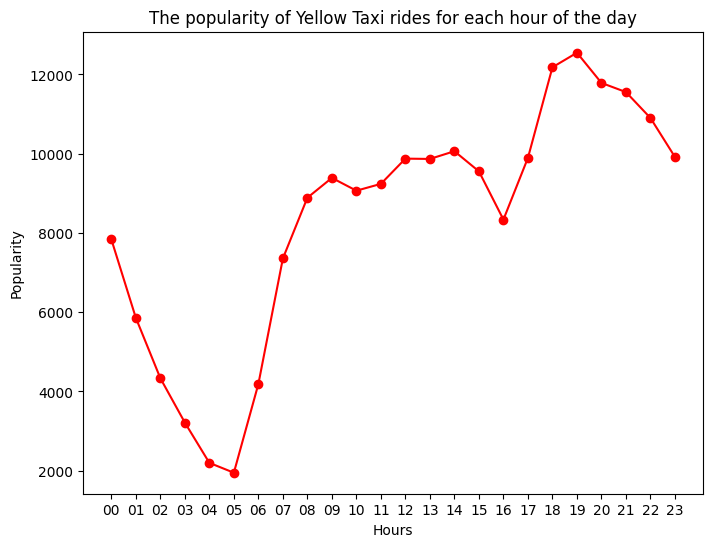

In [73]:
dataframe_v1 = get_data_for_popularity_of_taxi_for_each_hour_of_day()
plot_visual_popularity_of_taxi_for_each_hour_of_day(dataframe_v1)

### Visualization 2
Create a visualization that shows the average distance traveled per month

In [74]:
def plot_visual_average_distance_traveled_per_month(dataframe):
    fig = plt.figure(figsize=(8, 6))
    x, y = dataframe.iloc[:,0], dataframe.iloc[:,1]
    ci = 1.645 * y.std()/(dataframe.shape[0] ** 0.5)
    
    plt.plot(x, y, 'ro-')
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    
    plt.xlabel('Months')
    plt.ylabel('Average Distance Traveled')
    plt.title('The average distance traveled per month for both taxis and Ubers combined') 
    
    plt.show()

In [75]:
def get_data_for_average_distance_traveled_per_month():
    query = """
    WITH hired_trips
     AS (SELECT Strftime('%m', pickup_datetime) AS trip_date,
                distance
         FROM   taxi_trips
         UNION ALL
         SELECT Strftime('%m', pickup_datetime),
                distance
         FROM   uber_trips)
    SELECT trip_date, AVG(distance) FROM hired_trips
    GROUP BY trip_date
    ORDER BY trip_date ASC
    """
    return pd.read_sql_query(query, engine)

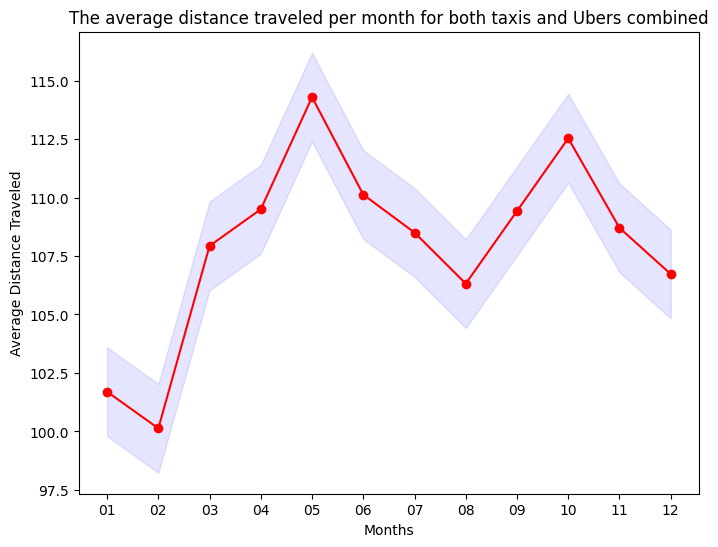

In [76]:
dataframe_v2 = get_data_for_average_distance_traveled_per_month()
plot_visual_average_distance_traveled_per_month(dataframe_v2)

### Visualization 3
Create a visualization that compares what day of the week was most popular for drop offs for each airport.

In [80]:
def plot_visual_most_popular_drop_offs_for_each_airport(df):
    fig = plt.figure(figsize=(8, 6))
    markers = {"LGA":"ro-", "JFK":"gd--", "EWR":"bs-."}
    for airport in df:
        dataframe = df[airport]
        x, y = dataframe.iloc[:,0], dataframe.iloc[:,1]
        plt.plot(x, y, markers[airport], label=airport)
    
    plt.xlabel('Days')
    plt.ylabel('Most popular drop offs')
    plt.legend()
    plt.title('The most popular for drop offs for each airport') 
    
    plt.show()

In [81]:
def get_data_for_most_popular_drop_offs_for_each_airport():
    
    NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
    LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
    JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
    EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))
    
    boxes = {"LGA":LGA_BOX_COORDS, "JFK":JFK_BOX_COORDS, "EWR":EWR_BOX_COORDS}
    
    df = {}
    for airport in boxes:
        coords = boxes[airport]
        lower_lat, lower_long = coords[0]
        upper_lat, upper_long = coords[1]
        

        query = f"""
        WITH hired_trips
         AS (SELECT Strftime('%w', pickup_datetime) AS trip_date,
                    dropoff_longitude, dropoff_latitude
             FROM   taxi_trips
             UNION ALL
             SELECT Strftime('%w', pickup_datetime),
                    dropoff_longitude, dropoff_latitude
             FROM   uber_trips)
        SELECT trip_date, COUNT(*) FROM hired_trips
        WHERE dropoff_longitude BETWEEN {lower_long} AND {upper_long} AND dropoff_latitude BETWEEN {lower_lat} AND {upper_lat}
        GROUP BY trip_date
        """
        df[airport]=pd.read_sql_query(query, engine)
        
    return df

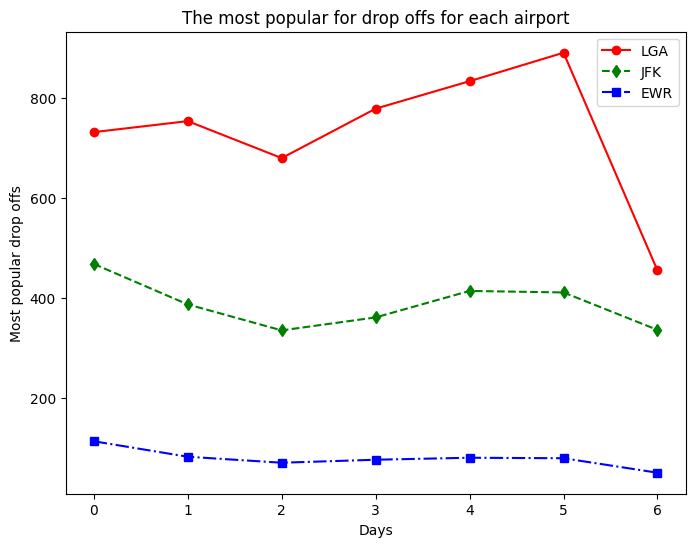

In [82]:
dataframe_v3 = get_data_for_most_popular_drop_offs_for_each_airport()
plot_visual_most_popular_drop_offs_for_each_airport(dataframe_v3)

### Visualization 4
Create a heatmap of all hired trips over a map of the area

In [83]:
def plot_visual_heatmap_of_all_hired_trips(dataframe):
    heatmap = KeplerGl(height = 400)
    heatmap.add_data(data = dataframe)
    display(heatmap)

In [84]:
def get_data_for_heatmap_of_all_hired_trips():
    query = """
    WITH hired_trips
     AS (SELECT pickup_longitude AS longitude, pickup_latitude AS latitude
         FROM   taxi_trips
         UNION ALL
         SELECT pickup_longitude AS longitude, pickup_latitude AS latitude
         FROM   uber_trips)
    SELECT * FROM hired_trips
    """
    return pd.read_sql_query(query, engine)

In [85]:
dataframe_v4 = get_data_for_heatmap_of_all_hired_trips()
plot_visual_heatmap_of_all_hired_trips(dataframe_v4)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

### Visualization 5
Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides

In [86]:
def plot_visual_compares_tip_amount_versus_distance(dataframe):
    fig = plt.figure(figsize=(8, 6))

    x, y = dataframe.iloc[:,0], dataframe.iloc[:,1]
    
    plt.scatter(x, y)
    plt.xlabel('Distance')
    plt.ylabel('Tip amount')
    plt.title('The comparison of tip amount versus distance') 
    
    plt.show()

In [87]:
def get_data_for_compares_tip_amount_versus_distance():
    query = """
    SELECT distance, tip_amount FROM taxi_trips WHERE tip_amount > 0
    """
    return pd.read_sql_query(query, engine)

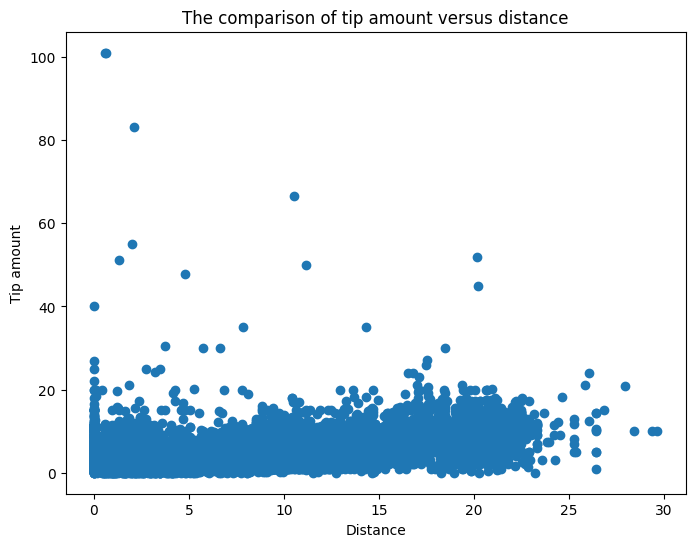

In [88]:
dataframe_v5 = get_data_for_compares_tip_amount_versus_distance()
plot_visual_compares_tip_amount_versus_distance(dataframe_v5)

### Visualization 6
Create scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides

In [92]:
def plot_visual_compares_tip_amount_versus_precipitation_amount(dataframe):
    fig = plt.figure(figsize=(8, 6))

    x, y = dataframe.iloc[:,0], dataframe.iloc[:,1]
    
    plt.scatter(x, y)
    plt.xlabel('Precipitation amount')
    plt.ylabel('Tip amount')
    plt.title('The comparison of tip amount versus precipitation amount') 
    
    plt.show()

In [100]:
def get_data_for_compares_tip_amount_versus_precipitation_amount():
    query = """
    SELECT precipitation, tip_amount FROM taxi_trips 
    INNER JOIN daily_weather
    ON DATE(daily_weather.weather_date) = DATE(taxi_trips.pickup_datetime)
    WHERE tip_amount > 0
    """
    return pd.read_sql_query(query, engine)

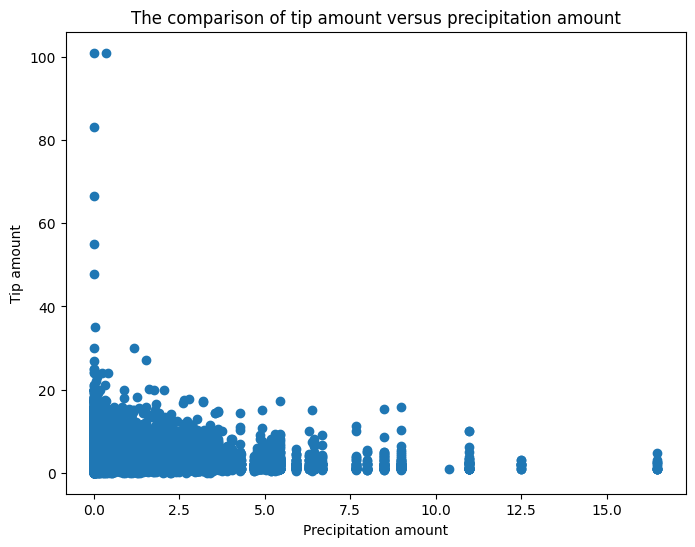

In [101]:
dataframe_v6 = get_data_for_compares_tip_amount_versus_precipitation_amount()
plot_visual_compares_tip_amount_versus_precipitation_amount(dataframe_v6)